# Classification

fetch_openml: to download real datasets
load: to download small toy datasets
make_: to generate fake datasets

In [1]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',as_frame=False)

In [2]:
X,y=mnist.data,mnist.target

In [3]:
X.shape  ## 70000 image and each has 784 features(28*28 pixels)

(70000, 784)

In [4]:
y.shape

(70000,)

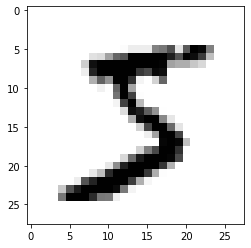

In [5]:
import matplotlib.pyplot as plt
def plot_digit(image_data):
    image=image_data.reshape(28,28)
    plt.imshow(image,cmap='binary')
    plt.axis='off'
    
some_digit=X[0]
plot_digit(some_digit)
plt.show()

In [6]:
y[0]

'5'

In [7]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

### Training a Binary Classifier

##### '5-Detector'

In [8]:
y_train_5=(y_train=='5')
y_test_5=(y_test=='5')

#### SGD Classifier
This classifier is capable of handling very large datasets efficiently.
SGD deals with training instances independently, one at a time,which makes it well suited for online learning


In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measure

### Accuracy 

In [11]:
# measuring accuracy using cross validation

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

To compare the accuracy, lets use dummy classifier that just classify every single image to most frequent
class i.e (in this case non_5)

In [12]:
from sklearn.dummy import DummyClassifier
dummy_clf=DummyClassifier()
dummy_clf.fit(X_train,y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [13]:
cross_val_score(dummy_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

Class Imbalance: In many real-world classification problems, the distribution of classes is imbalanced, meaning some classes have significantly more instances than others. In such cases, a high accuracy score can be misleading. A classifier may achieve high accuracy by simply predicting the majority class most of the time, while performing poorly on the minority class. This is especially problematic when the minority class is the one of interest (e.g., detecting fraud, rare diseases) as the classifier's true effectiveness is not adequately captured.

### Confusion Matrics

Confusion matrix is to count the number of times class A are misclassified as class B, for all A/B pairs. Each row in the confusion matric represents actual class and each column represents the predicted class. 

FP: type I error
FN: type II error

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_predict=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_train_5,y_train_predict)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

A perfect classifier would have only TP and TN, so its confusion matrix would have non zero values only on its main diagonal. 

In [16]:
y_train_predict=y_train_5
cm=confusion_matrix(y_train_5,y_train_predict)
cm

array([[54579,     0],
       [    0,  5421]], dtype=int64)

##### Precision and Recall

Accuracy of positive prediction: Precision
precision=TP/(TP+FP)

A trivial way to have perfect precision is to create a classifier that makes 99 negative prediction and 1 positive prediction
if this prediction is correct then the classifier is 100% accuracy. SUch classifier is not be very useful. So precision is typically used with one more metric called recall(sensitivity) or True Positve Rate(TPR)

Recall=TP/(TP+FN)

In [17]:
from sklearn.metrics import precision_score,recall_score

ps=precision_score(y_train_5,y_train_predict)
rs=recall_score(y_train_5,y_train_predict)
ps,rs

(1.0, 1.0)

When it claims that an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

#### F1 Score
F1 score: Harmonic mean of precision and recall,  whereas regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, tha classifier will only get high F1 score if both recall and precision is high.


In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_predict)

1.0

#### Precision Recall Trade-off

Increasing precision reduces recall and vice versa. this is called precision recall trade off

In [19]:
# setting threshold
y_score=sgd_clf.decision_function([some_digit]) # return decision scores that it uses to make prediction
y_score
# The decision score represents how confident the classifier is that the instance belongs to the
# positive class (class 1 in binary classification) versus the negative class (class 0).

array([2164.22030239])

In [20]:
threshold=0
y_some_digit_pred=(y_score>threshold)
y_some_digit_pred

array([ True])

This is because when you raise the threshold, the classifier becomes more conservative in making positive predictions, leading to fewer instances being classified as positive. As a result, true positives 
may decrease (leading to lower recall), but false positives may also decrease (leading to higher precision).

The relationship between precision and recall is usually inversely proportional, meaning that as you increase one, the other typically decreases. A higher threshold tends to increase precision and reduce recall, while a lower threshold increases recall and reduces precision.

High Threshold (Conservative classifier):

Fewer instances are classified as positive.
Higher precision (fewer false positives).
Lower recall (more false negatives).
Low Threshold (Generous classifier):

More instances are classified as positive.
Lower precision (more false positives).
Higher recall (fewer false negatives).
Choosing the right threshold is essential and depends on the specific problem's requirements and constraints. For example:

If the cost of false positives is high (e.g., misclassifying a legitimate transaction as fraud), you might want to use a high threshold to ensure high precision.
If the cost of false negatives is high (e.g., missing a critical medical diagnosis), you might prefer a low threshold to achieve high recall.

In [21]:
threshold=3000
y_some_digit_pred=(y_score>threshold) # increasing threshold decreases recall
y_some_digit_pred

array([False])

In [22]:
# how do we decide which threshold value to take
y_scores=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [23]:
y_scores.shape

(60000,)

In [24]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

Sorting:
The precision_recall_curve function first sorts the decision scores in descending order. Sorting is necessary to ensure that the thresholds are in increasing order, as precision and recall values need to be calculated for all possible thresholds.

Threshold Calculation:
The function then iterates through the sorted decision scores and treats each unique value as a threshold. For example, if there are N unique decision scores, there will be N-1 threshold points, as thresholds are calculated between consecutive unique scores.

Precision and Recall Calculation:
For each threshold, the function calculates the corresponding precision and recall values based on the predicted positive class labels using that threshold.
Precision is calculated as the ratio of true positives to the total number of instances predicted as positive (true positives + false positives).
Recall is calculated as the ratio of true positives to the total number of actual positive instances (true positives + false negatives).

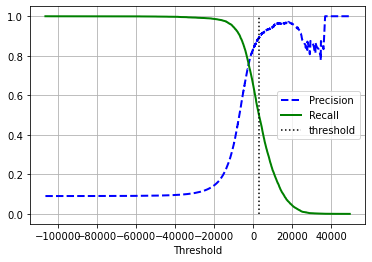

In [25]:
plt.plot(thresholds,precisions[:-1],"b--",label="Precision",linewidth=2)
plt.plot(thresholds,recalls[:-1],"g-",label="Recall",linewidth=2)
plt.vlines(threshold,0,1.0,"k","dotted",label="threshold")
plt.grid(True)
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

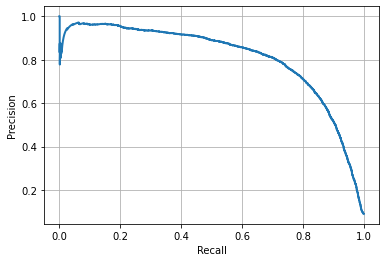

In [26]:
# Another way
plt.plot(recalls,precisions,linewidth=2,label="Precision/Recall Curve")
plt.grid(True)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

Select precision and recall according to your project requirements

In [27]:
# searching the lowest threshold for precision=90%
idx_for_90_precision=(precisions>=0.90).argmax()
threshold_for_90_precision=thresholds[idx_for_90_precision]
idx_for_90_precision,threshold_for_90_precision

(57075, 3370.0194991439557)

In [28]:
y_train_pred_90=(y_scores>=threshold_for_90_precision)

In [29]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [30]:
recall_at_90_precision=recall_score(y_train_5,y_train_pred_90)
recall_at_90_precision  ## If someone says you should find 99% precision you should ask at what % recall

0.4799852425751706

### ROC Curve

Receiver Operating Characteristic Curve plots the true positive rate(recall) against the false positive rate(fall-out/1-True Negative Rate/1-specificity).

In [31]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)

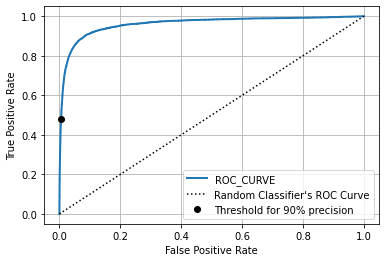

In [32]:
# plot to find the points with 90% precision
idx_for_threshold_at_90=(thresholds<=threshold_for_90_precision).argmax()
tpr_90,fpr_90=tpr[idx_for_threshold_at_90],fpr[idx_for_threshold_at_90]

plt.plot(fpr,tpr,linewidth=2,label="ROC_CURVE")
plt.plot([0,1],[0,1],'k:',label="Random Classifier's ROC Curve")
plt.plot([fpr_90],[tpr_90],"ko",label="Threshold for 90% precision") #90% threshold point
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## A good classifier stays as far away from Random Classifier's ROC Curve

#### Area under ROC curve- AUC
perfect classifier: 1
random classifier: 0.5

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

### Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

In [35]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [36]:
y_scores_forest=y_probas_forest[:,1]
precisions_forest,recalls_forest,thresholds_forest=precision_recall_curve(y_train_5,y_scores_forest)

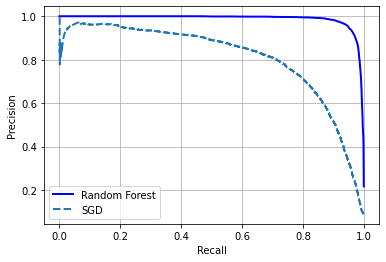

In [37]:
plt.plot(recalls_forest,precisions_forest,"b-",linewidth=2,label="Random Forest")
plt.plot(recalls,precisions,"--",linewidth=2,label="SGD")
plt.grid(True)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

In [38]:
y_train_pred_forest=y_probas_forest[:,1]>=0.5
f1_score(y_train_5,y_train_pred_forest)

0.9274509803921569

In [39]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [40]:
recall_score(y_train_5,y_train_pred_forest)

0.8725327430363402

In [41]:
precision_score(y_train_5,y_train_pred_forest)

0.9897468089558485

# Multiclass Classification

Logistic Regression, RandomForestClassifier, GaussianNB -> Multiclass Classifier
SGD Classifier, SVC -> Binary Classifier

One Vs All: train 10 binary classifier one for each. eg. 0-detector,1-detector...etc 
One Vs One: train a binary classifier for every pair of digit. total-n(n-1)/2;

### SVM

In [44]:
from sklearn.svm import SVC
svm_clf=SVC(random_state=42)
svm_clf.fit(X_train[:2000],y_train[:2000])
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [45]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores.round(2) # highest is 9.3 w.r.t. to 5

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [46]:
class_id=some_digit_scores.argmax()
class_id

5

In [47]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [48]:
svm_clf.classes_[class_id]

'5'

In [50]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000],y_train[:2000])
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [52]:
len(ovr_clf.estimators_)

10

### SGD

In [54]:
sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit]) # incorrect prediction

array(['3'], dtype='<U1')

In [55]:
some_digit_scores=sgd_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[-31893.03, -34419.69,  -9530.64,   1823.73, -22320.15,  -1385.8 ,
        -26188.91, -16147.51,  -4604.35, -12050.77]])

In [56]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [57]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

#### Confusion Matrix

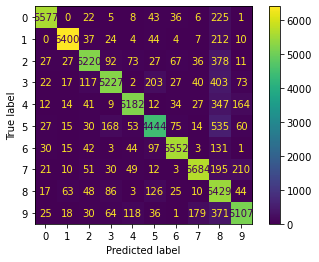

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay
y_train_pred=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred)
plt.show()

Notice that the cell on the diagonal in row #5, col #5 looks darker than the other digits. This could be because the model made more errors on 5s, or there are fewer 5s in the dataset than the other digits. That's why it is important to normalize the confusion matrix by dividing each value by total no of images in the corresponding class 

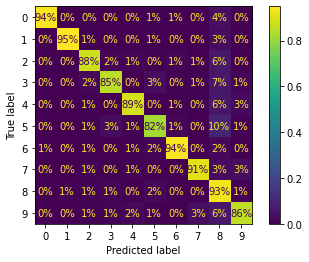

In [61]:
## Normalized CM
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,normalize="true",values_format=".0%")
plt.show()

Now we can easily see that only 82% of the images of 5s were classified correctly. The most common error the model made with images of 5s was to misclassify them as 8s: This happened for 10% of all 5s. But only 2% of 8s got misclassified as 5s.

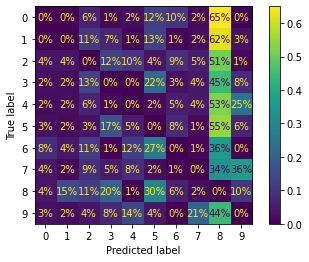

In [62]:
# if you look closly you will notice that many digit are misclassified as 8. 
sample_weight=(y_train_pred!=y_train)
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,sample_weight=sample_weight,normalize="true",values_format=".0%")
plt.show()

# Now you can see the col 8 is brighter which confirms that many images got misclassified as 8. row #7 and col #9 =36% does not
# mean that 36% of images of 7 misclassified as 9. It means that 36% of errors the model made on image of 7s were misclassification 
# as 9s.

# Multilabel Classification

In [63]:
# classify that digit is larger than 7 or not and even or odd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>='7')
y_train_odd=(y_train.astype('int8')%2==1)
y_multilabel=np.c_[y_train_large,y_train_odd]
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier()

In [64]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [66]:
# evaluation metrics
y_train_knn_pred=cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred,average="macro")

0.976410265560605

If you wish to use a classifier that does not natively support multilabel classification, such as SVC, one possible strategy is to train one model per label. However, this strategy may have a hard time capturing the dependencise between the labels. For example, a large digit(7,8,9) is twice more likely to be odd than even, but the classifier for "odd" lebel does not know what the classifier for "large" label has predicted. To solve this issue, the model can be organised in chain: when a model makes a prediction, it uses the input feature plus all the predictions of the model that come before it in the chain.

In [68]:
from sklearn.multioutput import ClassifierChain
chain_clf=ClassifierChain(SVC(),cv=3,random_state=42)
chain_clf.fit(X_train[:2000],y_multilabel[:2000])
chain_clf.predict([some_digit])

array([[0., 1.]])

# Multioutput Classification

It is generalization of multilabel classification where each label can be multiclass.

In [71]:
## System to remove noise from an image

np.random.seed(42)
noise=np.random.randint(0,100,(len(X_train),784))
X_train_mod=X_train+noise
noise=np.random.randint(0,100,(len(X_test),784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

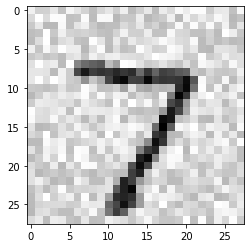

In [76]:
plot_digit(X_test_mod[0])
plt.show()

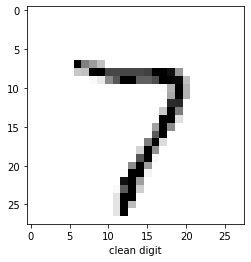

In [77]:
knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.xlabel('clean digit')
plt.show()